In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# Load environment variables
load_dotenv()

# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### Task Definition

In [3]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field


In [4]:
OperatorType = Literal["+", "-", "*", "/"]
TokenType = Union[float, OperatorType] # TokenType is a union of float, real number and OperatorType


In [7]:
class Equation(BaseModel):
    """The formula combining the provided numbers to reach the target of 24."""

    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation. Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7.",
    )

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]

In [11]:

class GuessEquations(BaseModel):
    """Submit multiple equations as guesses."""

    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )

    equations: List[Equation] = Field(
        description="The list of equations to submit as guesses."
    )




In [12]:
## These objects will represent a single "candidate" (or scored candidate) within our agent's state.
# You can update the candidate object to match your own task.


class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"

In [13]:
class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str

Fetch data

In [14]:
import requests
import csv

In [15]:

csv_data = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/game-of-24/24.csv"
).content.decode("utf-8")

In [17]:
# Get just the Puzzles column (column index 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

In [29]:
puzzles[0].split()


['1', '1', '4', '6']

In [18]:
print(f"Example puzzles: {puzzles[:3]}")


Example puzzles: ['1 1 4 6', '1 1 11 11', '1 1 3 8']


### Expander

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [20]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are playing the Game of 24. Using the provide numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        ("user", "Solve the 24 game for these numbers: {problem}.{candidate}"),
    ],
).partial(candidate="")

In [23]:
llm = ChatOpenAI(model="gpt-4o-mini")
bound_llm = llm.with_structured_output(GuessEquations)

In [26]:
solver = prompt | bound_llm


### Scorer

In [30]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(int, problem.split()))
    # Check that the candidate equation uses all 4 numbers exactly once
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, float)
    ]
    if sorted(used_numbers) != sorted(numbers):
        score = 0
        feedback = "The equation must use all 4 numbers exactly once."
        return ScoredCandidate(
            candidate=candidate.candidate, score=score, feedback=feedback
        )
    try:
        result = candidate.candidate.compute()
        score = 1 / (1 + abs(24 - result))
        feedback = f"Result: {result}"
    except Exception as e:
        score = 0
        feedback = f"Invalid equation. Error: {repr(e)}"
    return ScoredCandidate(
        candidate=candidate.candidate, score=score, feedback=feedback
    )

### Graph

In [31]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph

In [32]:

from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver

In [33]:
def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates

In [34]:
class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]

In [35]:
class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int

In [36]:
def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 10),
        "threshold": config.get("threshold", 0.9),
        "k": configurable.get("k", 5),
        "beam_size": configurable.get("beam_size", 3),
    }

In [37]:
class ExpansionState(ToTState):
    seed: Optional[Candidate]

In [38]:
def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
    """Generate the next state."""
    configurable = _ensure_configurable(config)
    if not state.get("seed"):
        candidate_str = ""
    else:
        candidate_str = "\n\n" + str(state["seed"])
    try:
        equation_submission = solver.invoke(
            {
                "problem": state["problem"],
                "candidate": candidate_str,
                "k": configurable["k"],
            },
            config=config,
        )
    except Exception:
        return {"candidates": []}
    new_candidates = [
        Candidate(candidate=equation) for equation in equation_submission.equations
    ]
    return {"candidates": new_candidates}

In [39]:
def score(state: ToTState) -> Dict[str, List[float]]:
    """Evaluate the candidate generations."""
    candidates = state["candidates"]
    scored = []
    for candidate in candidates:
        scored.append(compute_score(state["problem"], candidate))
    return {"scored_candidates": scored, "candidates": "clear"}

In [40]:
def prune(
    state: ToTState, *, config: RunnableConfig
) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_configurable(config)["beam_size"]
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate[1], reverse=True
    )
    pruned = organized[:beam_size]
    return {
        # Update the starting point for the next iteration
        "candidates": pruned,
        # Clear the old memory
        "scored_candidates": "clear",
        # Increment the depth by 1
        "depth": 1,
    }

In [41]:
def should_terminate(
    state: ToTState, config: RunnableConfig
) -> Union[Literal["__end__"], Send]:
    configurable = _ensure_configurable(config)
    solved = state["candidates"][0].score >= configurable["threshold"]
    if solved or state["depth"] >= configurable["max_depth"]:
        return "__end__"
    return [
        Send("expand", {**state, "somevalseed": candidate})
        for candidate in state["candidates"]
    ]

In [42]:
# Create the graph
builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

In [43]:
# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

In [45]:
# Add edges
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

In [46]:
# Set entry point
builder.add_edge("__start__", "expand")

In [47]:
# Compile the graph
graph = builder.compile(checkpointer=MemorySaver())

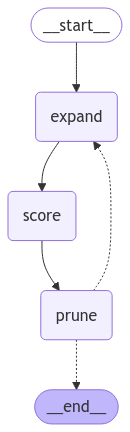

In [48]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Run